# Link to GitHub Repo: https://github.com/yanhan2023/DLH_project_sansformer.git

# Prepare Environment

In [1]:
import time
starttime = time.time()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
!pip install yacs
!pip install einops
!pip install torch_optimizer
!pip install prettytable

# Introduction
The challenge of applying Transformer models to Electronic Health Records (EHR) lies in their complex, multidimensional structure, which sometimes causes these sophisticated models to underperform compared to simpler methods. This gap highlights a missed opportunity to leverage Transformers' advantages, such as efficient transfer learning and scalability, within the realm of EHR analysis.

Addressing this issue, the paper titled "SANSformers: Self-Supervised Forecasting in Electronic Health Records with Attention-Free Models" introduces the SANSformer model. This innovative, attention-free sequential model is specifically designed to navigate the unique complexities of EHR data, with a focus on enhancing predictions for future healthcare utilization. This enhancement is crucial for effectively managing healthcare resources, especially for diverse patient subgroups with distinct health trajectories, including those with rare diseases. The paper also employs a self-supervised pre-training strategy known as Generative Summary Pretraining (GSP), aimed at predicting future health trends from past records.

Our project aims to replicate the findings of this seminal paper, especially its performance on predicting mortality rate on MIMIC data. By doing so, we seek to validate the potential of attention-free models and GSP techniques in improving healthcare resource prediction and management.


# Scope of Reproducibility:

The paper established three tasks to evaluate model performance: 1) The number of physical visits to healthcare centers. 2) The counts of physical visits due to six specific disease categories. 3) predicting the probability of inpatient mortality. The first two tasks are both performed on the Pummel dataset, which is a confidential dataset. Therefore, we focus on reproducing the third task, which is performed on MIMIC-IV. We will train a SANSformer model on patient history, excluding the two most recent visits from each patient. Thus effectively predict the probability of mortality following the subsequent two visits. The tal_expire_flag feature from the MIMIC admissions table will be used as the label for mortality. After training, we will compare its AUC with that of several baseline models including logistic regression, RETAIN, BEHRT, BRLTM and SARD.  



# Methodology

In [5]:
# import  packages you need
import os
import time
import sys
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import torch
from matplotlib.pyplot import Line2D
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    f1_score,
    mean_absolute_error,
    mean_poisson_deviance,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [6]:
# TODO: change root_path to project path
root_path = ''
# root_path = '/content/drive/MyDrive/Colab_Notebooks/DLH/src'
code_path = root_path
full_data_path = os.path.join(root_path, 'preprocessed_data')
sys.path.append(root_path)

import dataset.loaders as loaders
import utils.common as common
from models.mimic_additive_sansformer import MimicAdditiveSansformerModel
from models.mimic_axial_sansformer import MimicAxialSansformerModel
from trainers.mimic_trainer import Trainer_MIMIC
from trainers.base_trainer import BaseTrainer

##  Data

0. For sake of simplicity and dataset storage limits, we load the mimic_iv_2.2 preprocessed data here, generated from the sourcecode preprocess.py.
* Create paths for the data loader.

In [7]:
parser = argparse.ArgumentParser(description="parser")
parser.add_argument("--cfg", dest="cfg_file", help="Config file", required=True, type=str)
parser.add_argument(
        "opts",
        help="See src/config.py for all options",
        default=None,
        nargs=argparse.REMAINDER,
    )
cfg_file_path = os.path.join(code_path, 'configs/config_axial_sansformer.yml')
args = parser.parse_args(['--cfg', cfg_file_path])
cfg = common.handle_config_and_log_paths(args)

In [8]:
cfg.defrost()
cfg.PATHS.DATAPATH = full_data_path
cfg.PATHS.VECTORIZER_PATH = os.path.join(full_data_path, 'vectorizer.pickle')

In [ ]:
# TODO: the saved model is too large to upload to GitHub, download from the link and use its path in config
pretrained_model_link = 'https://drive.google.com/file/d/1_uv_v7DWI6CR8hon1q7F_Q_fHDyRkfG0/view?usp=sharing'
cfg.PATHS.PRETRAINED_TRANSFORMER_FILE = ''
# cfg.PATHS.PRETRAINED_TRANSFORMER_FILE = os.path.join(code_path, 'results/at_2024_04_12_00_05_14/saved_models/model.pth')

In [9]:
(train_dataloader, val_dataloader, test_dataloaders) = loaders.get_mimic_dataloaders(cfg)

Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Training: Stats
count    15371.000000
mean         7.205192
std          7.565050
min          3.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        236.000000
Name: seq_length, dtype: float64
Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los


In [10]:
cfg.OPTIM.STEPS_PER_EPOCH = len(train_dataloader) // cfg.MODEL.ACCU_GRAD_STEPS
cfg.MODEL.VOCAB_SIZE = train_dataloader.dataset.vectorizer.seq_vocab_len

We create the main dataframe by grouping all icd codes associated with each patient per admission from the original .csv files.

For example, preprocess.py groups all diagnosis code from diagnoses_icd.csv.gz and generates a .feather file.

Then, by merging all these grouped .feather files, we created the final patient dataset grouped_patient_rem.


1. Group diagnosis codes ```icd_all``` asscoaited with each patient ```subject_id``` according to his/her admission id ```hadm_id```.

* The preprocessing includes putting all the above 3 cols in one group_dict by utilizing the tqdm package.
* ```subject_id``` and ```hadm_id``` are the group keys, with a value of " " in case of nan diagnoses codes value.
* Same preprocessing techniques for the following dataset.

In [11]:
import pandas as pd

grouped_diag_df = pd.read_feather(full_data_path + '/grouped_diag.feather')
print(grouped_diag_df.head())
print(grouped_diag_df.describe())

   subject_id   hadm_id                                            icd_all
0    10467237  20000019  IP9_038 IP9_590 IP9_753 IP9_584 IP9_276 IP9_99...
1    16925328  20000024  IP10_D50 IP10_K52 IP10_I10 IP10_E53 IP10_M81 I...
2    19430048  20000034  IP10_K83 IP10_K86 IP10_K86 IP10_K86 IP10_R10 I...
3    18910522  20000041  IP9_715 IP9_250 IP9_V85 IP9_401 IP9_272 IP9_V4...
4    11146739  20000057  IP9_719 IP9_719 IP9_996 IP9_E88 IP9_E84 IP9_46...
         subject_id       hadm_id
count  4.308520e+05  4.308520e+05
mean   1.500753e+07  2.500309e+07
std    2.877524e+06  2.888221e+06
min    1.000003e+07  2.000002e+07
25%    1.251542e+07  2.250159e+07
50%    1.501270e+07  2.500660e+07
75%    1.749606e+07  2.750474e+07
max    1.999999e+07  2.999993e+07


2. Group procedure codes ```proc_all``` asscoaited with each patient ```subject_id``` according to his/her admission id ```hadm_id```.

In [12]:
grouped_proc_df = pd.read_feather(full_data_path + '/grouped_proc.feather')
print(grouped_proc_df.head())
print(grouped_proc_df.describe())

   subject_id   hadm_id                                      proc_all
0    18910522  20000041                                       IP9_815
1    14546051  20000069                             IP10_0KQ IP10_10E
2    13074106  20000102                               IP9_735 IP9_730
3    14990224  20000147  IP10_021 IP10_B21 IP10_021 IP10_06B IP10_5A1
4    12640657  20000235               IP9_372 IP9_885 IP9_452 IP9_399
         subject_id       hadm_id
count  2.294450e+05  2.294450e+05
mean   1.501013e+07  2.500072e+07
std    2.879863e+06  2.886367e+06
min    1.000003e+07  2.000004e+07
25%    1.251432e+07  2.250563e+07
50%    1.501590e+07  2.499771e+07
75%    1.750698e+07  2.750109e+07
max    1.999999e+07  2.999983e+07


3. Group drug codes ```drg_all``` asscoaited with each patient ```subject_id``` according to his/her admission id ```hadm_id```.

In [13]:
grouped_drg_df = pd.read_feather(full_data_path + '/grouped_drg.feather')
print(grouped_drg_df.head())
print(grouped_drg_df.describe())

   subject_id   hadm_id  drg_all
0    10467237  20000019  720 872
1    16925328  20000024  663 812
2    18910522  20000041  302 470
3    14546051  20000069  560 775
4    14046553  20000094  194 291
         subject_id       hadm_id
count  3.119570e+05  3.119570e+05
mean   1.500942e+07  2.500296e+07
std    2.880352e+06  2.889658e+06
min    1.000003e+07  2.000002e+07
25%    1.251266e+07  2.250071e+07
50%    1.500961e+07  2.500641e+07
75%    1.750732e+07  2.750845e+07
max    1.999999e+07  2.999983e+07


4. Group drug codes ```service_all``` asscoaited with each patient ```subject_id``` according to his/her admission id ```hadm_id```.

In [14]:
grouped_service_df = pd.read_feather(full_data_path + '/grouped_service.feather')
print(grouped_service_df.head())
print(grouped_service_df.describe())

   subject_id   hadm_id service_all
0    10467237  20000019         MED
1    16925328  20000024         MED
2    19430048  20000034         MED
3    18910522  20000041       ORTHO
4    11146739  20000057         MED
         subject_id       hadm_id
count  4.312310e+05  4.312310e+05
mean   1.500766e+07  2.500314e+07
std    2.877498e+06  2.888180e+06
min    1.000003e+07  2.000002e+07
25%    1.251557e+07  2.250155e+07
50%    1.501288e+07  2.500669e+07
75%    1.749622e+07  2.750470e+07
max    1.999999e+07  2.999993e+07


5. Merge all the grouped datasets and create the test/train sets.

In [15]:
grouped_patient_rem2_df = pd.read_feather(full_data_path + '/grouped_patient_rem2.feather')

mimic_train_rem2_df = pd.read_feather(full_data_path + '/mimic_train_rem2.feather')

mimic_test_rem2_df = pd.read_feather(full_data_path + '/mimic_test_rem2.feather')

The training set has 35058 data points and the test set has 8765 data points. Each has 25 features and 1 target.

In [16]:
print("Training set shape: ", mimic_train_rem2_df.shape)
print("Test set shape: ", mimic_test_rem2_df.shape)

Training set shape:  (35058, 26)
Test set shape:  (8765, 26)


In [17]:
mimic_train_rem2_df.describe()

,subject_id,seq_length,encoded_gender,encoded_ethnicity,encoded_language
count,3.505800e+04,35058.000000,35058.000000,35058.000000,35058.000000
mean,1.500361e+07,3.920218,0.469194,12.350990,0.895060
std,2.879765e+06,5.800473,0.499057,6.536986,0.306481
min,1.000003e+07,1.000000,0.000000,0.000000,0.000000
25%,1.250449e+07,1.000000,0.000000,9.000000,1.000000
50%,1.501819e+07,2.000000,0.000000,9.000000,1.000000
75%,1.748134e+07,4.000000,1.000000,15.000000,1.000000
max,1.999978e+07,236.000000,1.000000,32.000000,1.000000


In [18]:
mimic_test_rem2_df.describe()

,subject_id,seq_length,encoded_gender,encoded_ethnicity,encoded_language
count,8.765000e+03,8765.000000,8765.000000,8765.000000,8765.000000
mean,1.499825e+07,3.825214,0.469139,12.293098,0.893326
std,2.884189e+06,5.361426,0.499075,6.438045,0.308716
min,1.000140e+07,1.000000,0.000000,0.000000,0.000000
25%,1.253293e+07,1.000000,0.000000,9.000000,1.000000
50%,1.494788e+07,2.000000,0.000000,9.000000,1.000000
75%,1.749759e+07,4.000000,1.000000,15.000000,1.000000
max,1.999877e+07,93.000000,1.000000,32.000000,1.000000


##   Model

Due to the huge amount of time required to run an epoch on our trained model, we loaded the pre-trained model instead to comply with the 8-min runtime limit.

### Model definition

In [19]:
class Trainer_MIMIC(BaseTrainer):
    def __init__(self, cfg, model, train_dataloader, val_dataloader, test_dataloaders):
        super().__init__(cfg, model, train_dataloader, val_dataloader, test_dataloaders)

        self.epoch_log_variables = {
            "y_outcomes": [],
            "y_los": [],
            "y_bin_preds": [],
            "y_los_preds": [],
        }

    def _init_log_variables(self):
        for k, _ in self.epoch_log_variables.items():
            self.epoch_log_variables[k] = []

    def plot_training_curves(self):
        loss_fig_save_path = os.path.join(self.cfg.PATHS.OUT_DIR, "training_losses.png")

        with plt.style.context("seaborn-muted"):
            # plot training curves
            fig, ax = plt.subplots(
                nrows=2, ncols=2, figsize=(14, 8), constrained_layout=True
            )
            steps_grid = np.arange(len(self.training_metrics["lr"])) + 1

            x_grid = np.arange(len(self.training_metrics["loss"])) + 1
            min_loss_at = np.argmin(np.array(self.validation_metrics["loss"]))

            ax.flat[0].plot(
                x_grid, self.validation_metrics["loss"], label="Val Loss", marker="o"
            )
            ax.flat[0].plot(
                x_grid, self.training_metrics["loss"], label="Train Loss", marker="o"
            )
            ax.flat[0].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[0].set_xlabel("Epochs")
            ax.flat[0].set_ylabel("Loss")
            ax.flat[0].set_title("Total Loss Curve")
            ax.flat[0].legend()

            min_loss_at = np.argmin(np.array(self.validation_metrics["los_loss"]))

            ax.flat[2].plot(
                x_grid,
                self.validation_metrics["los_loss"],
                label="Val Loss",
                marker="o",
            )
            ax.flat[2].plot(
                x_grid,
                self.training_metrics["los_loss"],
                label="Train Loss",
                marker="o",
            )
            ax.flat[2].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[2].set_xlabel("Epochs")
            ax.flat[2].set_ylabel("Loss")
            ax.flat[2].set_title("LoS Loss Curve")
            ax.flat[2].legend()

            min_loss_at = np.argmin(np.array(self.validation_metrics["bin_loss"]))

            ax.flat[3].plot(
                x_grid,
                self.validation_metrics["bin_loss"],
                label="Val Loss",
                marker="o",
            )
            ax.flat[3].plot(
                x_grid,
                self.training_metrics["bin_loss"],
                label="Train Loss",
                marker="o",
            )
            ax.flat[3].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[3].set_xlabel("Epochs")
            ax.flat[3].set_ylabel("Loss")
            ax.flat[3].set_title("Bin. Loss Curve")
            ax.flat[3].legend()

            fig.savefig(loss_fig_save_path)

        return

    def compute_dist_metrics(self, log_variables: dict):
        "Note: log_variables is available from state, passing in dummy arg for clarity"
        # override base trainer

        return_dict = {}

        y_bin_pred = np.array(self.epoch_log_variables["y_bin_preds"])
        y_bin_pred_thresh = (y_bin_pred > 0.5).astype(np.int8)
        y_bin_true = np.array(self.epoch_log_variables["y_outcomes"])

        y_los_pred = np.array(self.epoch_log_variables["y_los_preds"])
        y_los_true = np.array(self.epoch_log_variables["y_los"])

        # metrics
        auc_bin = roc_auc_score(y_bin_true, y_bin_pred)

        spearman_los, _ = stats.spearmanr(y_los_true, y_los_pred)
        # r2_los = r2_score(y_los_true, y_los_pred)

        return_dict = {
            "auc_bin": auc_bin,
            "spearman_los": spearman_los,
        }

        return return_dict

    def run_epoch(self, split, dataloader, epoch_count=0):
        assert split.lower() in ("train", "validation", "test")

        self._init_log_variables()

        is_train = True if split.lower() == "train" else False
        self.model.train(is_train)

        lr = 0.0
        losses = []
        bin_losses = []
        los_losses = []
        pbar = (
            tqdm(enumerate(dataloader), total=len(dataloader))
            if is_train
            else enumerate(dataloader)
        )
        self.model.zero_grad()
        acc_steps = self.cfg.MODEL.ACCU_GRAD_STEPS
        for it, batch in pbar:
            # place data on the correct device
            batch_dict = self._prepare_batch(batch)
            # forward the model
            with torch.set_grad_enabled(is_train):
                with autocast(enabled=self.cfg.USE_AMP):
                    (
                        loss,
                        bin_loss,
                        los_loss,
                        y_pred_bin,
                        y_los_pred,
                        y_los_true,
                        patient_vec,
                    ) = self.model(**batch_dict)
            report_loss = loss
            if is_train:
                loss = loss / acc_steps
                # backprop and update the parameters
                self.grad_scaler.scale(loss).backward()
                if (it + 1) % self.cfg.MODEL.ACCU_GRAD_STEPS == 0:
                    self.grad_scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_value_(
                        self.model.parameters(), self.cfg.OPTIM.GRAD_CLIP_T
                    )
                    self.grad_scaler.step(self.optimizer)
                    self.grad_scaler.update()
                    self.model.zero_grad()

                    lr = 0.0
                    for param_group in self.optimizer.param_groups:
                        lr = param_group["lr"]

                    if self.cfg.OPTIM.LR_POLICY in ["1cycle"]:
                        self.scheduler.step()
                    self.training_metrics["lr"].append(lr)

                # report progress
                pbar.set_description(
                    f"epoch {epoch_count + 1} iter {it}: train loss {loss.item() * acc_steps:.5f} lr {lr:e}"
                )

            # store metrics for logging
            losses.append(report_loss.item())
            bin_losses.append(bin_loss.item())
            los_losses.append(los_loss.item())

            self.epoch_log_variables["y_outcomes"].extend(
                batch_dict["y_outcome"].cpu().detach().numpy().tolist()
            )
            self.epoch_log_variables["y_los"].extend(
                y_los_true.cpu().detach().numpy().tolist()
            )
            self.epoch_log_variables["y_bin_preds"].extend(
                y_pred_bin.cpu().detach().numpy().tolist()
            )
            self.epoch_log_variables["y_los_preds"].extend(
                y_los_pred.cpu().detach().numpy().tolist()
            )

        metrics_d = {
            "loss": float(np.mean(losses)),
            "bin_loss": float(np.mean(bin_losses)),
            "los_loss": float(np.mean(los_losses)),
        }

        if not is_train:
            pass
            metrics_d.update(self.compute_dist_metrics(self.epoch_log_variables))

        # compute metrics
        print_str = f"{split} epoch: {epoch_count+1} "
        for k, v in metrics_d.items():
            print_key = str(k)
            print_str += f" | {print_key}: {v:.5f}"

        print(print_str)
        print("=" * 100)
        return metrics_d

    def predict(self):
        print("=" * 100)
        best_epoch = self.load_best_score_checkpoint()
        print(f"loaded model from epoch: {best_epoch}")

        _ = self.run_epoch("validation", self.val_dataloader)

        # get test_loss
        test_epoch_metrics_l = []
        for i, test_loader in enumerate(self.test_dataloaders):
            test_epoch_metrics = self.run_epoch("test", test_loader)
            test_epoch_metrics_l.append(test_epoch_metrics)

        return test_epoch_metrics_l

In [20]:
MODEL_TYPE = {
    "add_SANSformer": MimicAdditiveSansformerModel,
    "axial_SANSformer": MimicAxialSansformerModel,
}
cfg.defrost()
cfg.OPTIM.MAX_EPOCHS = 2

In [21]:
common.seed_everything(cfg.RNG_SEED)

(
    train_dataloader,
    val_dataloader,
    test_dataloaders,
) = loaders.get_mimic_dataloaders(cfg)

Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Training: Stats
count    15371.000000
mean         7.205192
std          7.565050
min          3.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        236.000000
Name: seq_length, dtype: float64
Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Using seqlength of 200
icd_all
proc_all
drg_all
service_all
admission_type
insurance
marital_status
days_from_prev
los


In [22]:
model = MODEL_TYPE[cfg.MODEL.TYPE](cfg)

# initialize the trainer
trainer = Trainer_MIMIC(
    cfg, model, train_dataloader, val_dataloader, test_dataloaders
)

loaded pretrained model.
+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|           pummel_embed.token_embed.weight           |   466440   |
|                  ethn_embed.weight                  |    132     |
|    sansformer.0.sans_attention.proj_ch1.0.weight    |   65536    |
|     sansformer.0.sans_attention.proj_ch1.0.bias     |    512     |
|     sansformer.0.sans_attention.conv_proj.weight    |   40000    |
|      sansformer.0.sans_attention.conv_proj.bias     |    200     |
|     sansformer.0.sans_attention.proj_out.weight     |   32768    |
|      sansformer.0.sans_attention.proj_out.bias      |    128     |
|       sansformer.0.sans_attention.norm1.weight      |    128     |
|        sansformer.0.sans_attention.norm1.bias       |    128     |
|       sansformer.0.sans_attention.norm2.weight      |    256     |
|        

##Model Architecture
The trainer_MIMIC model contains a total of 1,953,357 trainable parameters. Indicating its capacity to model complex patterns and relationships in large-scale data effectively. The architecture suggests a deep, multi-layer transformer-based model, using repeated blocks of custom transformers (SANSformer and Visit SANSformer), each with projection, convolution, normalization, and feedforward components to deeply process and transform the input EHR data.
There are embedding layers(pummel_embed.token_embed.weight,ethn_embed.weight, etc.), SANSformer Layers, including projection and convolution layers(proj_ch1,conv_proj,proj_out,etc.), normalization layers(norm1,norm2,norm3,etc.), feedforward layers(ff,etc.).
Also there are activation functions, the specific activation functions used aren't directly listed in the module breakdown, but common choices in similar architectures include ReLU or GELU. After all there are binary output layers(bin_fc, etc.), These layers are the final stages in the network designed for binary classification tasks.


##Training Objective
The model aims to predict mortality rate and uses spearman loss for training. If the prediction is highly correlated with the ground truth, the model will have a small loss. It also uses AUC as another metric for model evaluation.


# Results


### Loss curve of training on MIMIC dataset for 20 epochs

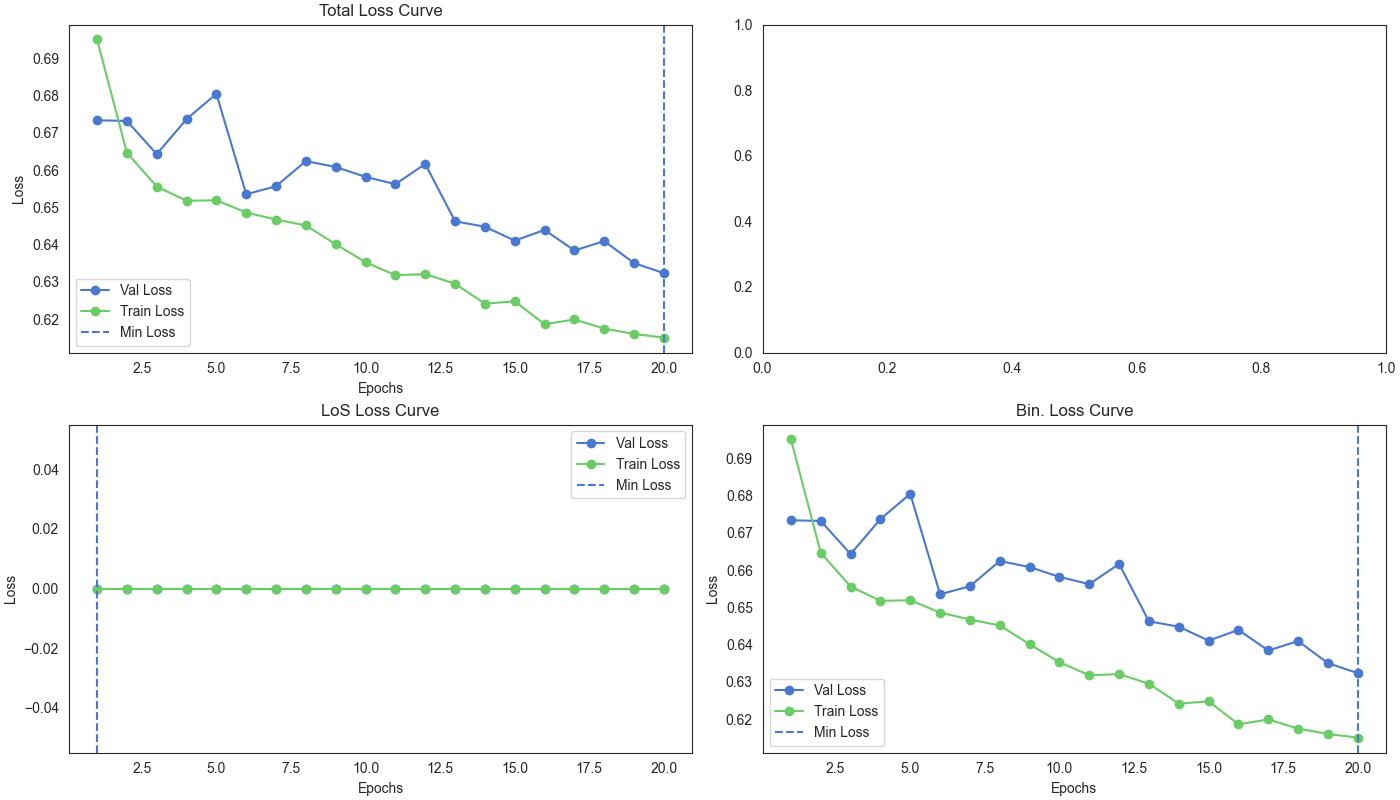

In [23]:
from google.colab.patches import cv2_imshow
training_curve_dir = os.path.join(code_path, 'results/at_2024_04_12_00_05_14/training_losses.png')

img = cv2.imread(training_curve_dir)
cv2_imshow(img)

### Model Evaluation

Test pretrained model

In [24]:
test_epoch_metrics_l = []
for i, test_loader in enumerate(test_dataloaders):
  if i == 0:
    test_epoch_metrics = trainer.run_epoch("test", test_loader)
    test_epoch_metrics_l.append(test_epoch_metrics)

test epoch: 1  | loss: 0.63946 | bin_loss: 0.63946 | los_loss: 0.00000 | auc_bin: 0.69387 | spearman_los: nan


In [25]:
print("Test AUC: %f" % test_epoch_metrics_l[0]['auc_bin'])

Test AUC: 0.693869


## Model comparison

In [26]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [27]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

'\nif you want to use an image outside this notebook for explanaition,\nyou can read and plot it here like the Scope of Reproducibility\n'

In [28]:
print((time.time() - starttime)/60)

5.423498010635376


# References

1.   Yogesh Kumar , Alexander Ilin , Henri Salo , et al. SANSformers: Self-Supervised Forecasting in Electronic Health Records with Attention-Free Models. TechRxiv. August 14, 2023.

